In [1]:
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd

# # To show the interactive widgets 
# %matplotlib widget
# from Pyriod import Pyriod #!This hates me. So just using LK
# import warnings

# # Suppress warning from Astropy module 
# # astropy.stats used in Pyriod is no longer supported
# from astropy.utils.exceptions import AstropyDeprecationWarning
# warnings.filterwarnings("ignore", category=AstropyDeprecationWarning)

# # Suppress invalid value runtime warning from Astropy and Pyriod 
# warnings.filterwarnings("ignore", category=RuntimeWarning) 

# from IPython.display import Image

# import lightkurve as lk

2.8124493919399574 d


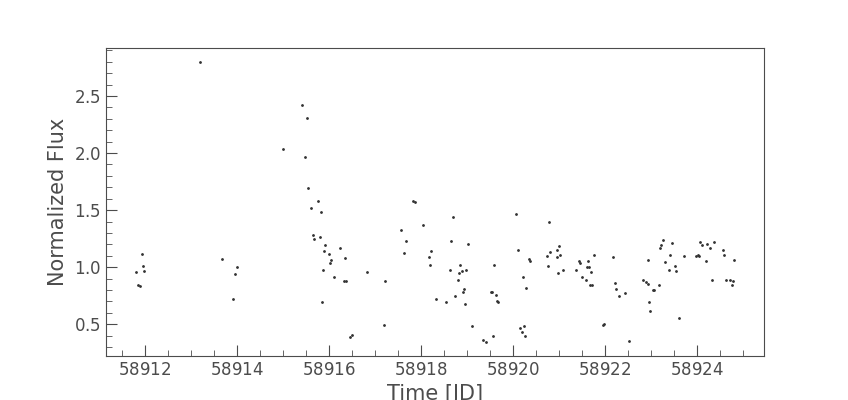

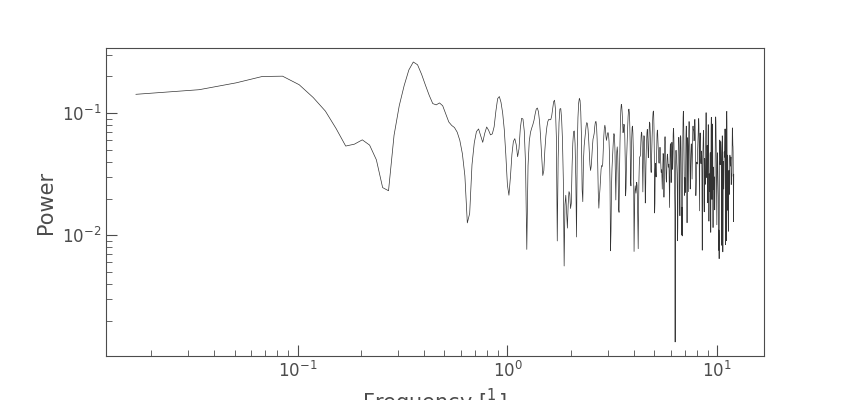

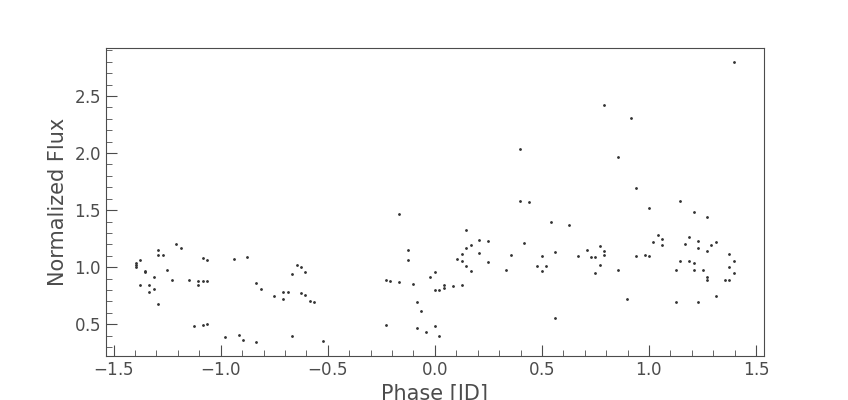

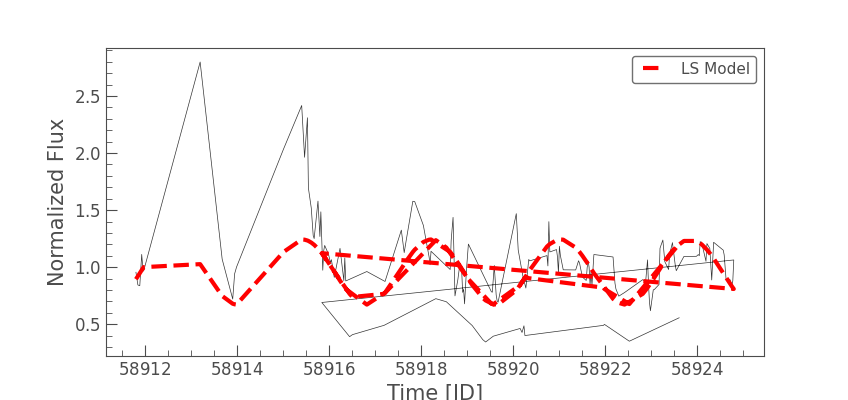

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lightkurve as lk
import astropy.units as u
%matplotlib widget



def lcPlots(fName):
    """
    Uses LightKurve to make LC plots from just a filename of a csv with flux and Time cols.
    """
    data = pd.read_csv(fName)
    fluxes = data["flux"]
    times = data["Time"]

    fluxErrs = np.ones_like(fluxes)*1e-4 #lk needs errors

    lc =lk.LightCurve(data=None, time=times, flux=fluxes, flux_err=fluxErrs)
    lc = lc.normalize()
    lc.scatter()
    pg = lc.to_periodogram()

    pg.plot(scale="log")
    period = pg.period_at_max_power
    print(period)
    lc.fold(period).scatter()

    lcModel = pg.model(time=lc.time, frequency=pg.frequency_at_max_power)
    ax = lc.plot()
    lcModel.plot(ax=ax, lw=3, ls='--',c='red')
    return lcModel


objName = "1999 JE82"


fName = f"./{objName}Matches.csv"
lcm = lcPlots(fName=fName)



{'_required_columns_relax': False,
 '_required_columns': ['time', 'flux', 'flux_err'],
 '_masked': False,
 '_column_class': astropy.table.column.Column,
 'columns': <TableColumns names=('time','flux','flux_err')>,
 'formatter': <astropy.table.pprint.TableFormatter at 0x7f77fb95d300>,
 '_copy_indices': True,
 '_init_indices': True,
 'primary_key': None,
 '_meta': {'FREQUENCY': <Quantity 0.35556195 1 / d>,
  'TARGETID': 'None LS Model',
  'LABEL': 'LS Model',
  'NORMALIZED': True},
 '_first_colname': 'time',
 '_required_columns_enabled': True,
 'pprint_exclude_names': <PprintIncludeExclude name=pprint_exclude_names value=None>,
 'pprint_include_names': <PprintIncludeExclude name=pprint_include_names value=None>,
 '_new_attributes_relax': False}

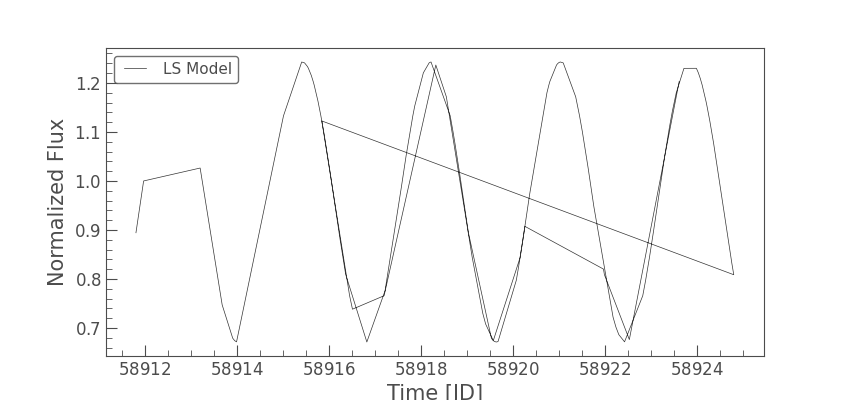

In [3]:
lcm.plot()
vars(lcm)


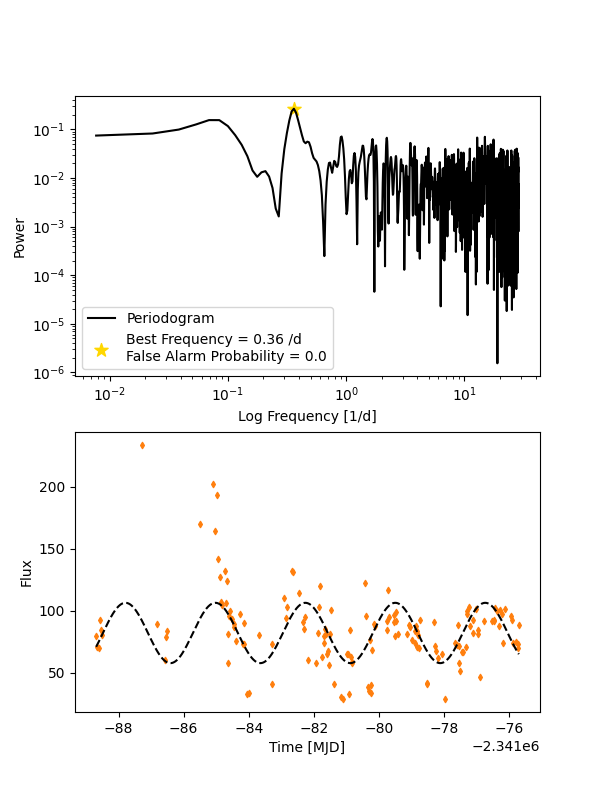

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib widget

from astropy.timeseries import LombScargle as lsp


fName = f"./{objName}Matches.csv"
data = pd.read_csv(fName)
fluxes = data["flux"]
times = data["Time"]-2400000.5


lsper = lsp(times*u.day, fluxes)#.autopower(samples_per_peak=50)
freqs, powers = lsper.autopower()
bestPow = np.max(powers)
bestFreq = freqs[np.argmax(powers)]
t_fit=np.linspace(times.min(),times.max(),1000)
y_fit = lsper.model(t_fit, bestFreq)

f_a_prob = lsper.false_alarm_probability(np.max(powers))

modelParams = lsper.model_parameters(bestFreq)

fig, ax = plt.subplots(2, figsize = (6,8))

ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set(xlabel="Log Frequency [1/d]", ylabel="Power")
ax[0].plot(freqs, powers, c="k", label="Periodogram")
ax[0].scatter(bestFreq,bestPow, c="gold",marker="*", s=100, label=f"Best Frequency = {bestFreq.round(2)} /d \nFalse Alarm Probability = {f_a_prob.round(3)}")
ax[0].legend()

ax[1].set(xlabel="Time [MJD]", ylabel="Flux")
ax[1].scatter(times, fluxes, label = "Light curve", c="tab:orange", marker = "d", s=10)
ax[1].plot(t_fit,y_fit, ls="--", c="k", label="Model")







In [41]:
lcdbDAT = pd.read_csv("F-D_BASIC.TXT",sep='\t',skiprows=4)#.drop(index=0, inplace=True)


lcdbDAT.drop(index=0, inplace=True)

print(len(lcdbDAT.index))

ind = 8998


# print(lcdbDAT.loc[[ind]].values[0][0][7:20].strip())
# print(lcdbDAT.loc[[ind]].values[0][0][58:65].strip())
# print(lcdbDAT.loc[[ind]].values[0][0][90:103].strip())
# print(lcdbDAT.loc[[ind]].values[0][0][74:83].strip())
# print(lcdbDAT.loc[[ind]].values[0][0][127:132].strip())


valList = []

for i in lcdbDAT.index:
    name = lcdbDAT.loc[[i]].values[0][0][7:20].strip() 
    hMag = float(lcdbDAT.loc[[i]].values[0][0][58:65])
    period = float(lcdbDAT.loc[[i]].values[0][0][90:100])
    uClass = lcdbDAT.loc[[i]].values[0][0][127:132].strip()
    diam = float(lcdbDAT.loc[[i]].values[0][0][74:83])
    valList.append([name, hMag, period, uClass, diam])

lcdbDf = pd.DataFrame(valList, columns=["Name","H","Period [Hours]","U", "Diameter"])

lcdbDf.to_csv("lcdbUseful.csv", sep=",")




8998


In [58]:
import pds4_tools

mainBeltWise = pds4_tools.read("./neowise_diameters_albedos_V2_0/data/neowise_mainbelt.xml")

# mbWiseXML = pd.read_xml("./neowise_diameters_albedos_V2_0/data/neowise_mainbelt.xml")

mainBeltWise.info()


Processing label: ./neowise_diameters_albedos_V2_0/data/neowise_mainbelt.xml
Now processing a Table_Delimited structure: TABLE
0   Table_Delimited  'TABLE'  22 fields x 178883 records


In [73]:
# pds4_tools.view("./neowise_diameters_albedos_V2_0/data/neowise_mainbelt.xml")

Processing label: ./neowise_diameters_albedos_V2_0/data/neowise_mainbelt.xml
Found a Table_Delimited structure: TABLE
Now processing a Table_Delimited structure: TABLE


In [89]:
mainBeltWise = pd.read_csv("./neowise_diameters_albedos_V2_0/data/neowise_mainbelt.csv", usecols=(0,1,11),header=None)
mainBeltWise.rename(columns = {0:"Number",1:"Name", 11:"Diameter"}, inplace=True)

def _name_cut(df, name:str, colName:str="Name"):
    "take a df and gives  only the values where the colName == name"
    toReturn = df.loc[df.index[df[colName]==name]]
    toReturn.reset_index(drop=True, inplace=True)
    return toReturn

for i, name in enumerate(lcdbDf["Name"]):
    nCut = _name_cut(mainBeltWise, name) 
    # print(name)
    try:
        wiseDiam = float(np.round(nCut["Diameter"].values,2))
        lcdbDiam = float(np.round(lcdbDf.at[i,"Diameter"].values,2))
    except Exception as e:
        print(e)
        print(nCut)
        break
        continue

    if  wiseDiam!=lcdbDiam :
        print(f"{name} has different diameters WISE:{wiseDiam} and LCDB{lcdbDiam}")


only length-1 arrays can be converted to Python scalars
Empty DataFrame
Columns: [Number, Name, Diameter]
Index: []


Text(0, 0.5, 'Period [Hrs]')

/tmp/ipykernel_1334607/3510406767.py:19: RuntimeWarning: divide by zero encountered in divide
  return 24/pers


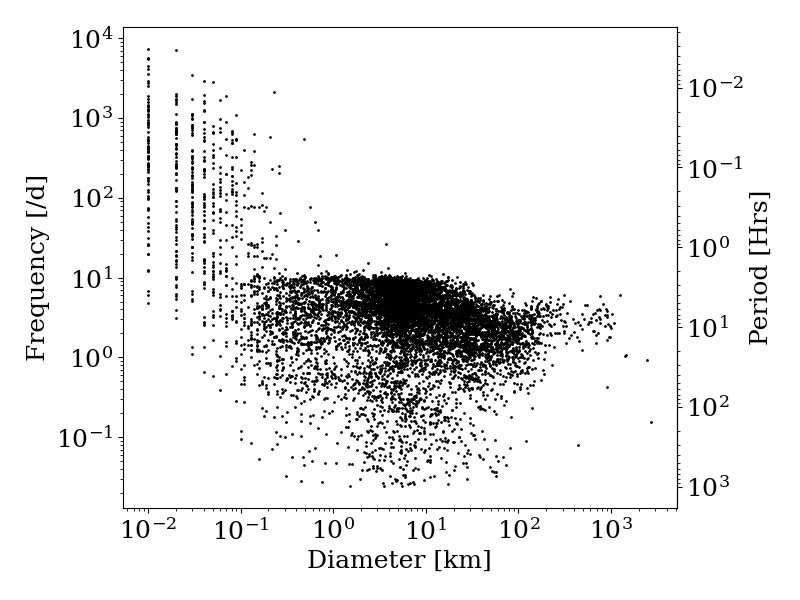

/tmp/ipykernel_1334607/3510406767.py:19: RuntimeWarning: divide by zero encountered in divide
  return 24/pers
/tmp/ipykernel_1334607/3510406767.py:19: RuntimeWarning: divide by zero encountered in divide
  return 24/pers
/tmp/ipykernel_1334607/3510406767.py:19: RuntimeWarning: divide by zero encountered in divide
  return 24/pers
/tmp/ipykernel_1334607/3510406767.py:19: RuntimeWarning: divide by zero encountered in divide
  return 24/pers
/tmp/ipykernel_1334607/3510406767.py:19: RuntimeWarning: divide by zero encountered in divide
  return 24/pers
/tmp/ipykernel_1334607/3510406767.py:19: RuntimeWarning: divide by zero encountered in divide
  return 24/pers
/tmp/ipykernel_1334607/3510406767.py:19: RuntimeWarning: divide by zero encountered in divide
  return 24/pers


In [49]:
plt.rcParams.update({
    "font.size": 18,
    "font.family": "serif",
    "figure.autolayout": True,
    "axes.grid": False,
    "xtick.minor.visible": False,
    # "ytick.minor.visible": True,
})


fig5, ax5= plt.subplots(figsize=(8,6))

ax5.set(xscale="log", yscale="log", xlabel=f"Diameter [km]", ylabel="Frequency [/d]")

ax5.scatter(lcdbDf["Diameter"], 24/lcdbDf["Period [Hours]"], s=1,c="k")

def perToFreq(pers):
    "assume pers in hrs, out in /d"
    return 24/pers

def freqToPer(freqs):
    "assume freqs in /d, out in hrs"
    return 24/freqs



ax6 = ax5.secondary_yaxis("right", functions=(freqToPer, perToFreq))
ax6.set_ylabel("Period [Hrs]")


In [9]:
bernoulliMPC = pd.read_csv("./bernoulli.txt")
from astropy.time import Time
from datetime import datetime
vals=[]
otherMagSystems = [] 


for i in bernoulliMPC.index:
    if bernoulliMPC.loc[[i]].values[0][0][15:19]=='2020':
        if bernoulliMPC.loc[[i]].values[0][0][20:22] == '02':
            day = int(round(float(bernoulliMPC.loc[[i]].values[0][0][23:28]),0))
            if day >=19 and day <=25:
                mag = bernoulliMPC.loc[[i]].values[0][0][65:71]
                try: 
                    int(mag) #should be a filter identified. A whole bunch of RA and Dec are too long and then don't even have a mag, so if it can be an int, it is not a mag
                    continue
                except:
                    
                    
                    date = bernoulliMPC.loc[[i]].values[0][0][15:28]

                    date = date.replace(" ", "-")

                    splitdate = date.split(".")
                    afterPoint = float(f"0.{splitdate[1]}")
                    hrs = afterPoint*24
                    mins = (hrs-int(hrs))*60
                    if hrs <10:
                        if mins <10:
                            date = f"{splitdate[0]} 0{int(hrs)}:0{int(mins)}"
                        else:
                            date = f"{splitdate[0]} 0{int(hrs)}:{int(mins)}"
                    elif mins <10:
                            date = f"{splitdate[0]} {int(hrs)}:0{int(mins)}"
                    else:
                            date = f"{splitdate[0]} {int(hrs)}:{int(mins)}"
                    if mag[-1] == "G":
                        vals.append([ round(Time(date).mjd,4), float(mag[:-1])])
                    else:
                        otherMagSystems.append([round(Time(date).mjd,4),mag])

inTimeDf = pd.DataFrame(vals, columns=["Date","Mag"])


print(np.unique(inTimeDf["Mag"]))

inTimeDf.to_csv("./MPC_Bernoulli_mags.csv", sep=",")


[14.7 14.8 14.9 15. ]


[20.46505 20.4758 ]
[0.08121896 0.05568096]
20.472749999999998
0.06963463378393088
20.401--20.651
0.24990000000000023
0.15549999999999997
1.6070739549839246


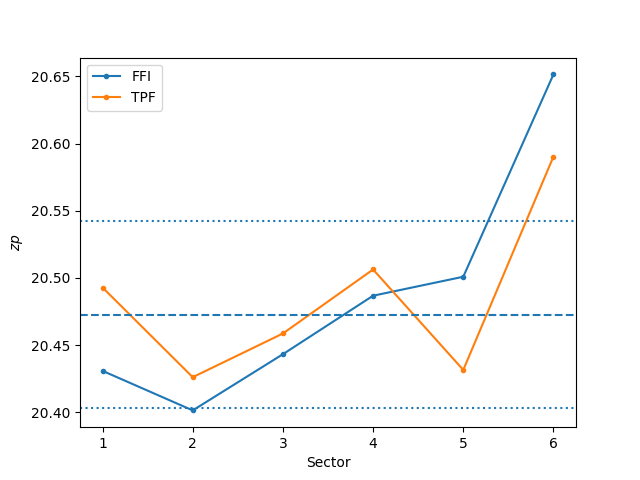

In [10]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib widget

if __name__ == '__main__':
	# Zeropoints:
	zp = np.array([
		[1, 20.4309, 20.4929],
		[2, 20.4015, 20.4262],
		[3, 20.4433, 20.4587],
		[4, 20.4868, 20.5063],
		[5, 20.5009, 20.4316],
		[6, 20.6514, 20.5903],
	])

	sector = zp[:,0]

	m = np.median(zp[:, 1:], axis=0)
	s = np.std(zp[:, 1:], axis=0)
	print( m )
	print( s )

	m2 = np.median(zp[:, 1:])
	s2 = np.std(zp[:, 1:])
	print(m2)
	print(s2)

	low = np.min(zp[:, 1:])
	high = np.max(zp[:, 1:])

	print('{0:.3f}--{1:.3f}'.format(low, high))
	range1 = high - low
	range2 = 20.4735 - 20.318
	print(range1)
	print(range2)
	print(range1 / range2)

	fig, ax = plt.subplots()
	ax.plot(sector, zp[:,1], '.-', label='FFI')
	#plt.fill_between([sector[0], sector[-1]], [m[0]+s[0], m[0]+s[0]], [m[0]-s[0], m[0]-s[0]], alpha=0.2)

	ax.plot(sector, zp[:,2], '.-', label='TPF')
	#plt.axhline(m[1], ls='--')
	#plt.axhline(m[1], ls='--')

	ax.axhline(m2, ls='--')
	ax.axhline(m2-s2, ls=':')
	ax.axhline(m2+s2, ls=':')

	ax.set_xlabel('Sector')
	ax.set_ylabel('$zp$')
	ax.xaxis.set_major_locator(MaxNLocator(integer=True))
	ax.legend()
	plt.show()

[0.526, 2]
[0.6, 1.4344296822031508]
[ 0.59748108 -0.4695137 ]
[0.00369238 0.06248213]


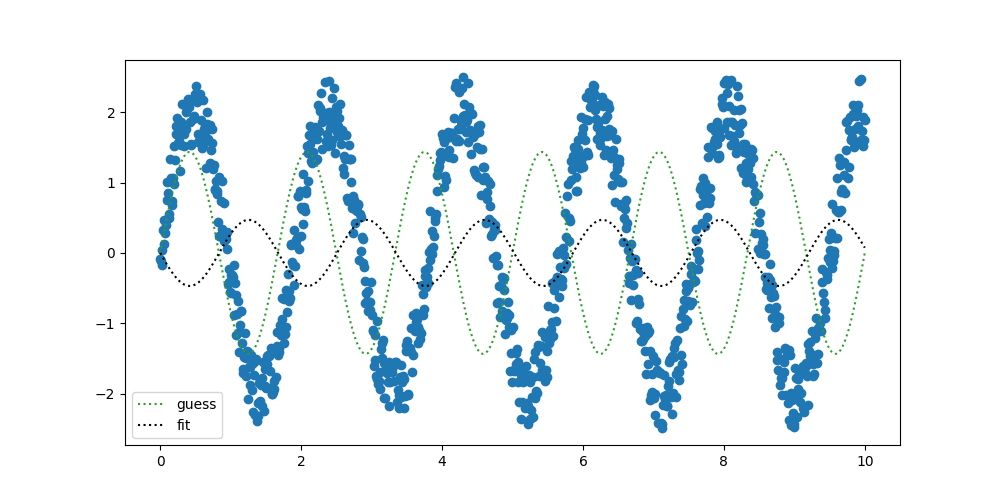

In [15]:
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

def sineFunc(t,freq,amp):
    return amp*np.sin(2*np.pi*(freq*t))


freq = 0.526
amp = 2

shouldBe = [freq,amp]
print(shouldBe)

ts = np.linspace(0,10,1000)
ys = amp*np.sin(2*np.pi*(freq*ts)) + 1*(np.random.rand(ts.shape[0])-0.5)

fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(ts,ys)

guessParams=[0.6, np.std(ys)]
print(guessParams)
plt.plot(ts, sineFunc(ts,*guessParams), c="tab:green", ls=":", label="guess")

popt, pcov =scipy.optimize.curve_fit(sineFunc, ts, ys, p0=guessParams)

print(popt)
print(np.sqrt(np.diag(pcov)))

ax.plot(ts, sineFunc(ts,*popt), c="k", ls=":", label="fit")

ax.legend()


In [12]:
np.linalg.cond(pcov)

5231.693841247454